# Deep learning - CNN 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, RNN

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)

In [4]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [5]:
def format_timeseries_data(df, input_length, output_length, target_names):
    
    if target_names is not None:
        target_indices = {name: i for i, name in enumerate(target_names)}
    col_indices = {name: i for i, name in enumerate(df.columns)}
    
    total_length = input_length + output_length
    
    input_slice = slice(0, input_length)
    output_slice = slice(input_length, None)
    
    data = np.array(df, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=total_length,
        sequence_stride=1,
        shuffle=False,
        batch_size=32
    )
    
    def split_to_input_output(x):
            
        inputs = x[:, input_slice, :]
        outputs = x[:, output_slice, :]
        
        if target_names is not None:
            outputs = tf.stack(
                [outputs[:,:,col_indices[name]] for name in target_names],
                axis=-1
            )

        inputs.set_shape([None, input_length, None])
        outputs.set_shape([None, output_length, None])
    
        return inputs, outputs
    
    ds = ds.map(split_to_input_output)
    
    return ds

In [6]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 2:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
lr_scheduler = LearningRateScheduler(scheduler)

def train_model(model, train_ds, val_ds, patience=5, max_epochs=50, use_scheduler=False):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[MeanAbsoluteError()])
    
    history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping])
    
    if use_scheduler == True:
        history = model.fit(train_ds, epochs=max_epochs, validation_data=val_ds, callbacks=[early_stopping, lr_scheduler])
    
    return history

In [7]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    ax1.plot(history.history['loss'], label='Train')
    ax1.plot(history.history['val_loss'], label='Validation')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='best')

    ax2.plot(history.history['mean_absolute_error'], label='Train')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validation')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.set_title('Mean absolute error')
    ax2.legend(loc='best')

    plt.tight_layout()

In [8]:
def plot_predictions(model, sample_batch, model_type):
    
    inputs, outputs = sample_batch
    preds = model(inputs)
    
    if model_type == 'single_step':      

        fig, ax = plt.subplots()

        actual_scaled = outputs.numpy().flatten()
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train
        
        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_step':

        fig, ax = plt.subplots()
        
        actual_scaled = outputs.numpy().flatten()[:48]
        actual = actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        predictions_scaled = preds.numpy().flatten()[:48]
        predictions = predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        ax.plot(actual, label='Actual')
        ax.plot(predictions, label='Predicted')
        ax.set_xlabel('Time steps')
        ax.set_ylabel('Oil temperature')
        ax.set_title('Predictions on a sample batch')
        ax.legend(loc='best')
        
    elif model_type == 'multi_output':
        
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)
        
        OT_actual_scaled = outputs.numpy().flatten()[0::2]
        OT_actual = OT_actual_scaled * (OT_max_test - OT_min_test) + OT_min_test
        
        OT_predictions_scaled = preds.numpy().flatten()[0::2]
        OT_predictions = OT_predictions_scaled * (OT_max_train - OT_min_train) + OT_min_train

        MULL_actual_scaled = outputs.numpy().flatten()[1::2]
        MULL_actual = MULL_actual_scaled * (MULL_max_test - MULL_min_test) + MULL_min_test
        
        MULL_predictions_scaled = preds.numpy().flatten()[1::2]
        MULL_predictions = MULL_predictions_scaled * (MULL_max_train - MULL_min_train) + MULL_min_train
        
        ax1.plot(OT_actual, label='Actual')
        ax1.plot(OT_predictions, label='Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Oil temperature')
        ax1.legend(loc='best')
        ax1.set_title('Predictions on a sample batch')
        
        ax2.plot(MULL_actual, label='Actual')
        ax2.plot(MULL_predictions, label='Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('MULL')
        ax2.legend(loc='best')
        
    plt.tight_layout()

In [9]:
def plot_evaluation(model_list, mae):
    
    fig, ax = plt.subplots()
    
    ax.bar(model_list, mae, width=0.3)
    ax.set_ylabel('MAE')
    ax.set_xlabel('Models')
    ax.set_ylim(0, max(mae)+0.15)
    for index, value in enumerate(mae):
        ax.text(x=index, y=value+0.005, s=str(round(value, 3)), ha='center')
    
    plt.tight_layout()

In [10]:
MULL_max_train = 7.568999767303468
MULL_min_train = -5.934000015258789
MULL_max_test = 4.690999984741211
MULL_min_test = -3.3399999141693115

OT_max_train = 46.00699996948242
OT_min_train = -4.079999923706056
OT_max_test = 17.165000915527347
OT_min_test = 3.025000095367432

## Single-step model 

In [11]:
KERNEL_LENGTH = 6
OUTPUT_LENGTH = 1
INPUT_LENGTH = OUTPUT_LENGTH + KERNEL_LENGTH - 1

train_ds_ss = format_timeseries_data(train_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
val_ds_ss = format_timeseries_data(val_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
test_ds_ss = format_timeseries_data(test_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])

ss_sample_batch = next(iter(test_ds_ss))

In [12]:
ss_cnn = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ss_cnn_history = train_model(ss_cnn, train_ds_ss, val_ds_ss, use_scheduler=True)

Epoch 1/50
381/381 [==============================] - 3s 3ms/step - loss: 0.0119 - mean_absolute_error: 0.0683 - val_loss: 0.0058 - val_mean_absolute_error: 0.0609
Epoch 2/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0046 - mean_absolute_error: 0.0516 - val_loss: 0.0096 - val_mean_absolute_error: 0.0734
Epoch 3/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0042 - mean_absolute_error: 0.0490 - val_loss: 0.0072 - val_mean_absolute_error: 0.0667
Epoch 4/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0038 - mean_absolute_error: 0.0462 - val_loss: 0.0160 - val_mean_absolute_error: 0.0982
Epoch 5/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0431 - val_loss: 0.0033 - val_mean_absolute_error: 0.0453
Epoch 6/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0388 - val_loss: 0.0085 - val_mean_absolute_error: 0.0686
Epoch 7/50
381/3

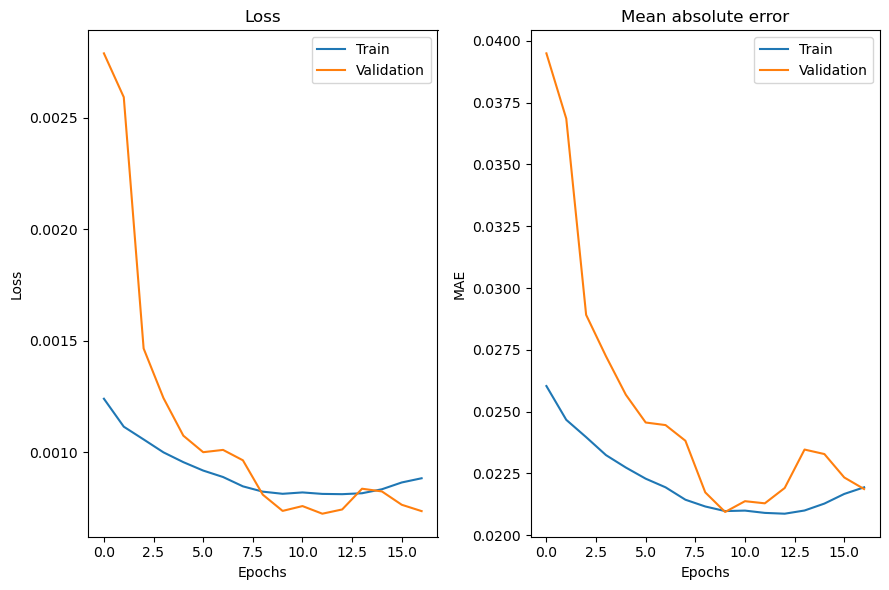

In [13]:
plot_history(ss_cnn_history)

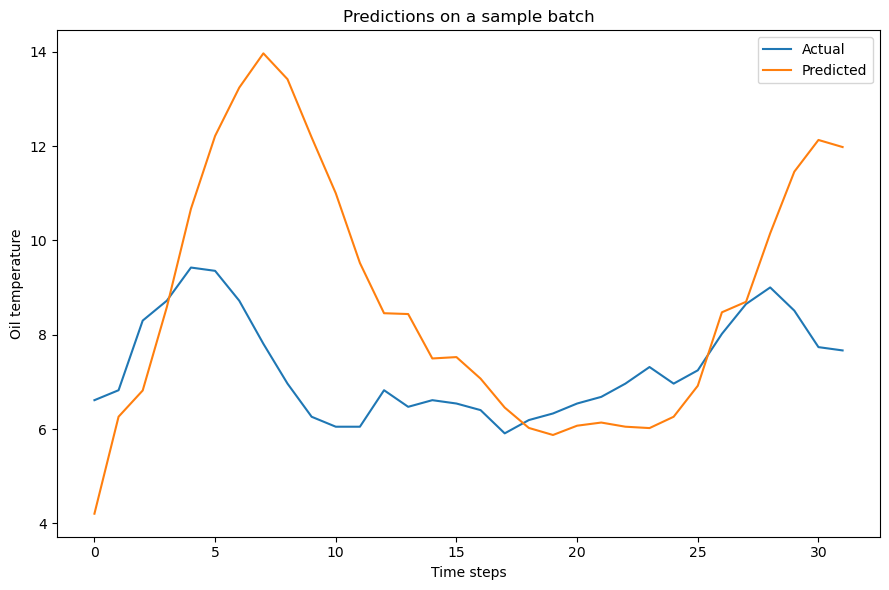

In [14]:
plot_predictions(ss_cnn, ss_sample_batch, 'single_step')

### Combine CNN and LSTM 

In [15]:
ss_cnn_lstm = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    Dense(1)
])

ss_cnn_lstm_history = train_model(ss_cnn_lstm, train_ds_ss, val_ds_ss, use_scheduler=True)

Epoch 1/50
381/381 [==============================] - 4s 5ms/step - loss: 0.0085 - mean_absolute_error: 0.0625 - val_loss: 0.0063 - val_mean_absolute_error: 0.0639
Epoch 2/50
381/381 [==============================] - 1s 4ms/step - loss: 0.0037 - mean_absolute_error: 0.0464 - val_loss: 0.0021 - val_mean_absolute_error: 0.0365
Epoch 3/50
381/381 [==============================] - 1s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0409 - val_loss: 0.0122 - val_mean_absolute_error: 0.0935
Epoch 4/50
381/381 [==============================] - 1s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0386 - val_loss: 0.0238 - val_mean_absolute_error: 0.1309
Epoch 5/50
381/381 [==============================] - 1s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0392 - val_loss: 0.0173 - val_mean_absolute_error: 0.1081
Epoch 6/50
381/381 [==============================] - 1s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0389 - val_loss: 0.0185 - val_mean_absolute_error: 0.1129
Epoch 7/50
381/3

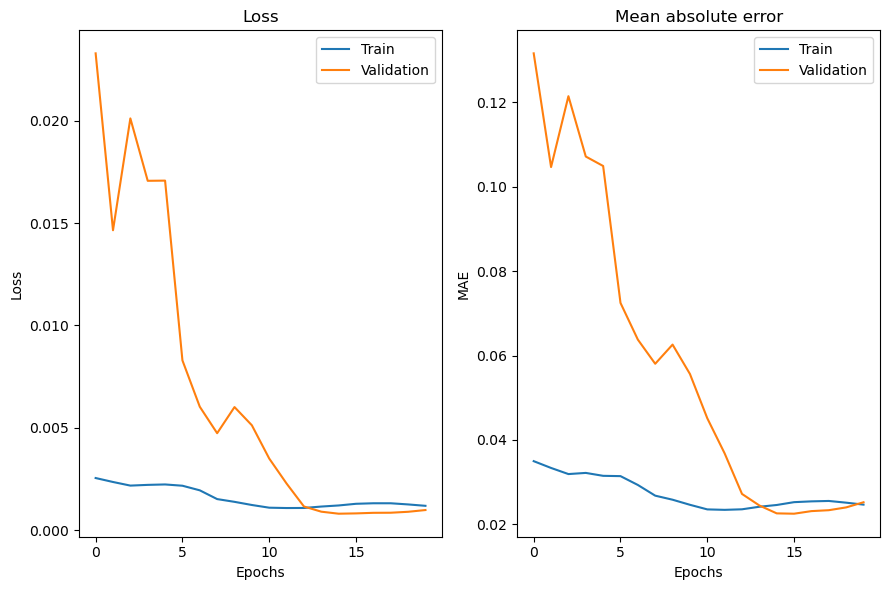

In [16]:
plot_history(ss_cnn_lstm_history)

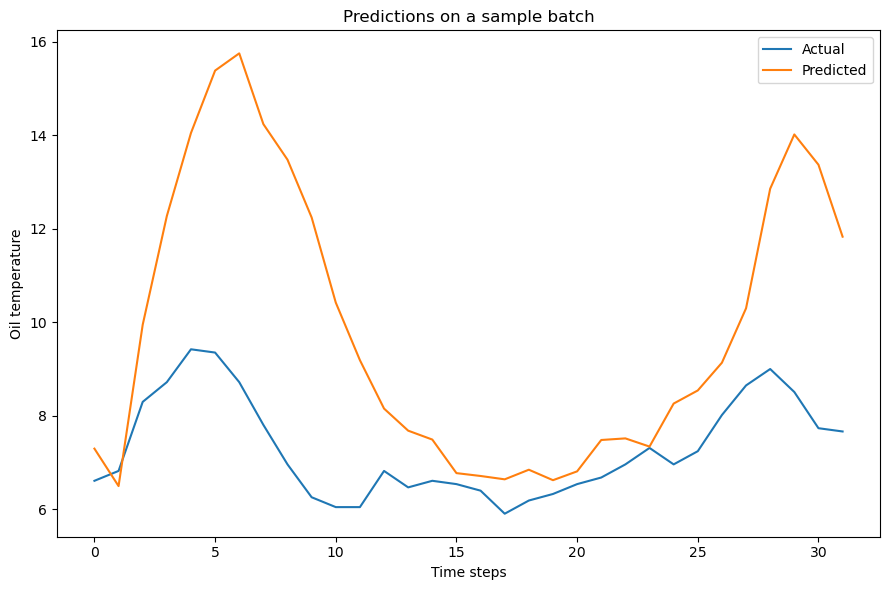

In [17]:
plot_predictions(ss_cnn_lstm, ss_sample_batch, 'single_step')

### Evaluation 

55/55 [==============================] - 0s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0626


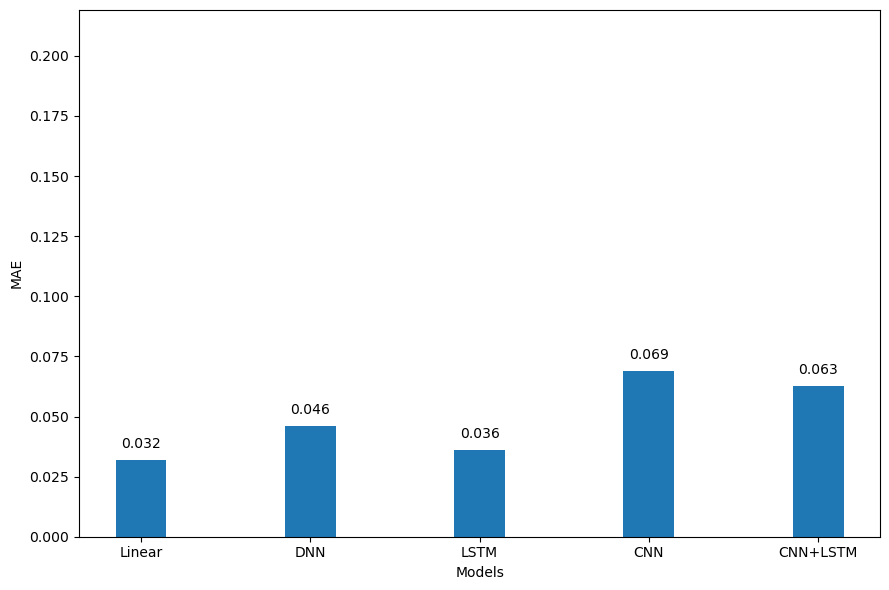

In [18]:
model_list = ['Linear', 'DNN', 'LSTM', 'CNN', 'CNN+LSTM']

ss_mae = [0.032, 0.046, 0.036]
ss_mae.append(ss_cnn.evaluate(test_ds_ss)[1])
ss_mae.append(ss_cnn_lstm.evaluate(test_ds_ss)[1])

plot_evaluation(model_list, ss_mae)

## Multi-step model 

In [19]:
KERNEL_LENGTH = 6
OUTPUT_LENGTH = 24
INPUT_LENGTH = OUTPUT_LENGTH + KERNEL_LENGTH - 1

train_ds_ms = format_timeseries_data(train_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
val_ds_ms = format_timeseries_data(val_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])
test_ds_ms = format_timeseries_data(test_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT'])

ms_sample_batch = next(iter(test_ds_ms))

In [20]:
ms_cnn = Sequential([
    Conv1D(32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

ms_cnn_history = train_model(ms_cnn, train_ds_ms, val_ds_ms)

Epoch 1/50
380/380 [==============================] - 2s 4ms/step - loss: 0.0279 - mean_absolute_error: 0.0919 - val_loss: 0.0223 - val_mean_absolute_error: 0.1231
Epoch 2/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0058 - mean_absolute_error: 0.0590 - val_loss: 0.0079 - val_mean_absolute_error: 0.0685
Epoch 3/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0051 - mean_absolute_error: 0.0552 - val_loss: 0.0035 - val_mean_absolute_error: 0.0478
Epoch 4/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0052 - mean_absolute_error: 0.0552 - val_loss: 0.0043 - val_mean_absolute_error: 0.0526
Epoch 5/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0053 - mean_absolute_error: 0.0554 - val_loss: 0.0042 - val_mean_absolute_error: 0.0520
Epoch 6/50
380/380 [==============================] - 1s 3ms/step - loss: 0.0056 - mean_absolute_error: 0.0564 - val_loss: 0.0041 - val_mean_absolute_error: 0.0530
Epoch 7/50
380/3

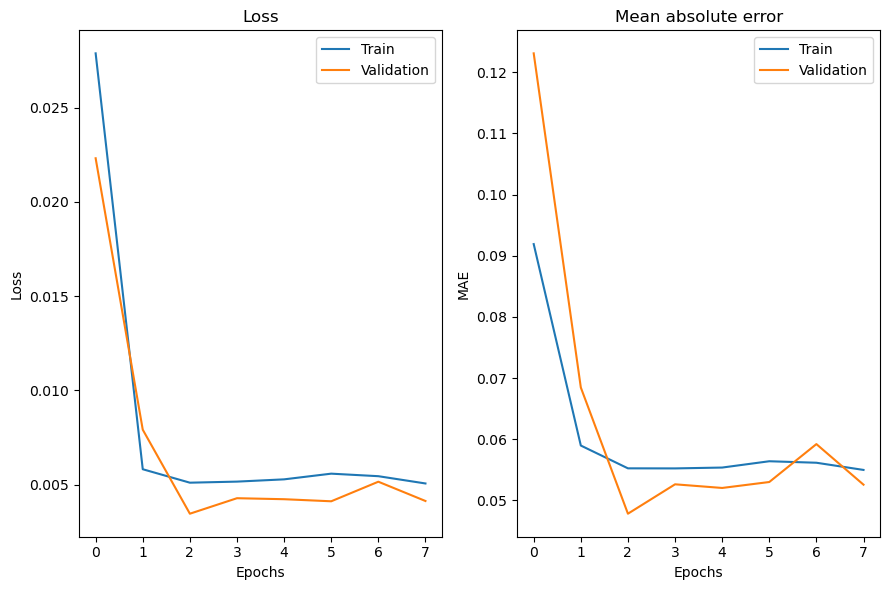

In [21]:
plot_history(ms_cnn_history)
# plot_predictions(ms_cnn, ms_sample_batch, 'multi_step')

### Combine CNN and LSTM 

In [22]:
ms_cnn_lstm = Sequential([
    Conv1D(32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    Dense(1)
])

ms_cnn_lstm_history = train_model(ms_cnn_lstm, train_ds_ms, val_ds_ms, use_scheduler=True)

Epoch 1/50
380/380 [==============================] - 13s 23ms/step - loss: 0.0144 - mean_absolute_error: 0.0780 - val_loss: 0.0123 - val_mean_absolute_error: 0.0954
Epoch 2/50
380/380 [==============================] - 8s 21ms/step - loss: 0.0092 - mean_absolute_error: 0.0673 - val_loss: 0.0166 - val_mean_absolute_error: 0.1160
Epoch 3/50
380/380 [==============================] - 8s 20ms/step - loss: 0.0094 - mean_absolute_error: 0.0688 - val_loss: 0.0244 - val_mean_absolute_error: 0.1438
Epoch 4/50
380/380 [==============================] - 8s 20ms/step - loss: 0.0091 - mean_absolute_error: 0.0687 - val_loss: 0.0466 - val_mean_absolute_error: 0.1964
Epoch 5/50
380/380 [==============================] - 8s 20ms/step - loss: 0.0070 - mean_absolute_error: 0.0635 - val_loss: 0.0337 - val_mean_absolute_error: 0.1634
Epoch 6/50
380/380 [==============================] - 8s 20ms/step - loss: 0.0059 - mean_absolute_error: 0.0589 - val_loss: 0.0100 - val_mean_absolute_error: 0.0809
Epoch 7/5

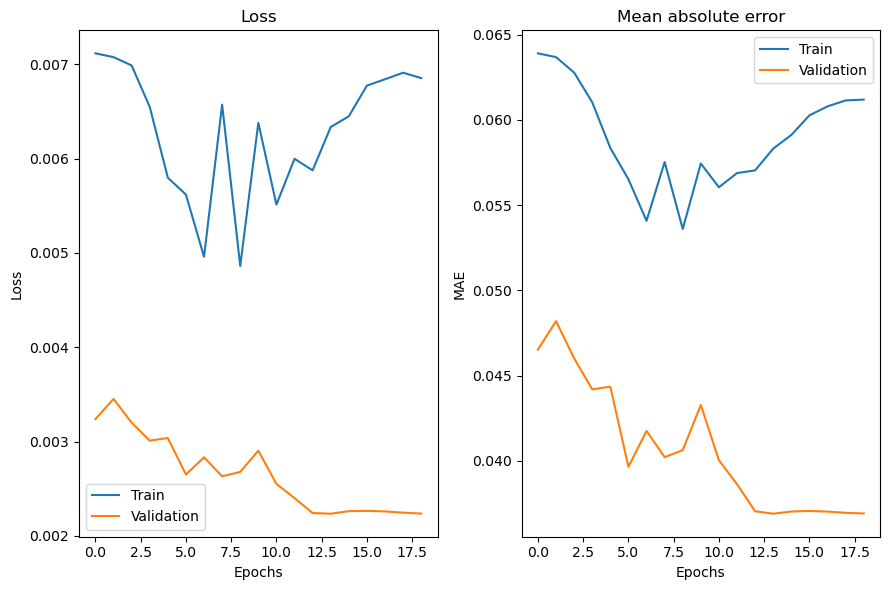

In [23]:
plot_history(ms_cnn_lstm_history)
# plot_predictions(ms_cnn_lstm, ms_sample_batch, 'multi_step')

### Evaluation 

53/53 [==============================] - 0s 6ms/step - loss: 0.0550 - mean_absolute_error: 0.1945


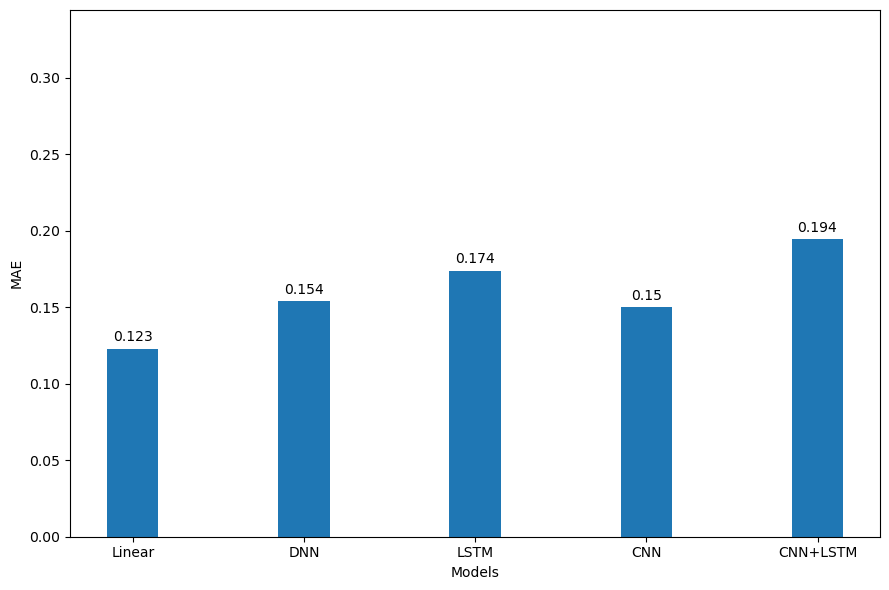

In [24]:
ms_mae = [0.123, 0.154, 0.174]
ms_mae.append(ms_cnn.evaluate(test_ds_ms)[1])
ms_mae.append(ms_cnn_lstm.evaluate(test_ds_ms)[1])

plot_evaluation(model_list, ms_mae)

## Multi-output 

In [25]:
KERNEL_LENGTH = 6
OUTPUT_LENGTH = 1
INPUT_LENGTH = OUTPUT_LENGTH + KERNEL_LENGTH - 1

train_ds_mo = format_timeseries_data(train_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT', 'MULL'])
val_ds_mo = format_timeseries_data(val_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT', 'MULL'])
test_ds_mo = format_timeseries_data(test_df, INPUT_LENGTH, OUTPUT_LENGTH, ['OT', 'MULL'])

mo_sample_batch = next(iter(test_ds_mo))

In [26]:
mo_cnn = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=2)
])

mo_cnn_history = train_model(mo_cnn, train_ds_mo, val_ds_mo)

Epoch 1/50
381/381 [==============================] - 2s 4ms/step - loss: 0.0108 - mean_absolute_error: 0.0713 - val_loss: 0.0605 - val_mean_absolute_error: 0.1870
Epoch 2/50
381/381 [==============================] - 2s 5ms/step - loss: 0.0050 - mean_absolute_error: 0.0532 - val_loss: 0.0299 - val_mean_absolute_error: 0.1341
Epoch 3/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0047 - mean_absolute_error: 0.0510 - val_loss: 0.0128 - val_mean_absolute_error: 0.0899
Epoch 4/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0036 - mean_absolute_error: 0.0452 - val_loss: 0.0110 - val_mean_absolute_error: 0.0819
Epoch 5/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0033 - mean_absolute_error: 0.0436 - val_loss: 0.0036 - val_mean_absolute_error: 0.0476
Epoch 6/50
381/381 [==============================] - 1s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0448 - val_loss: 0.0032 - val_mean_absolute_error: 0.0440
Epoch 7/50
381/3

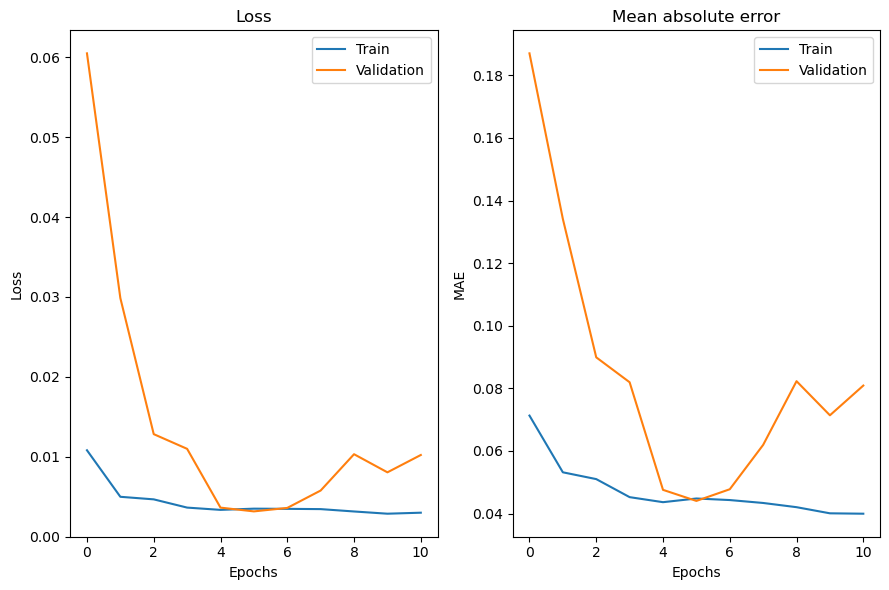

In [27]:
plot_history(mo_cnn_history)
# plot_predictions(mo_cnn, mo_sample_batch, 'multi_output')

### Combine CNN and LSTM 

In [28]:
mo_cnn_lstm = Sequential([
    Conv1D(filters=32, kernel_size=(KERNEL_LENGTH,), activation='relu'),
    LSTM(units=32, return_sequences=True),
    LSTM(units=16, return_sequences=True),
    Dense(units=2)
])

mo_cnn_lstm_history = train_model(mo_cnn_lstm, train_ds_mo, val_ds_mo, use_scheduler=True)

Epoch 1/50
381/381 [==============================] - 7s 8ms/step - loss: 0.0273 - mean_absolute_error: 0.0971 - val_loss: 0.0093 - val_mean_absolute_error: 0.0786
Epoch 2/50
381/381 [==============================] - 2s 5ms/step - loss: 0.0096 - mean_absolute_error: 0.0718 - val_loss: 0.0131 - val_mean_absolute_error: 0.0942
Epoch 3/50
381/381 [==============================] - 2s 5ms/step - loss: 0.0087 - mean_absolute_error: 0.0685 - val_loss: 0.0204 - val_mean_absolute_error: 0.1134
Epoch 4/50
381/381 [==============================] - 2s 5ms/step - loss: 0.0068 - mean_absolute_error: 0.0623 - val_loss: 0.0230 - val_mean_absolute_error: 0.1143
Epoch 5/50
381/381 [==============================] - 2s 5ms/step - loss: 0.0057 - mean_absolute_error: 0.0575 - val_loss: 0.0160 - val_mean_absolute_error: 0.0936
Epoch 6/50
381/381 [==============================] - 2s 5ms/step - loss: 0.0052 - mean_absolute_error: 0.0547 - val_loss: 0.0094 - val_mean_absolute_error: 0.0745
Epoch 1/50
381/3

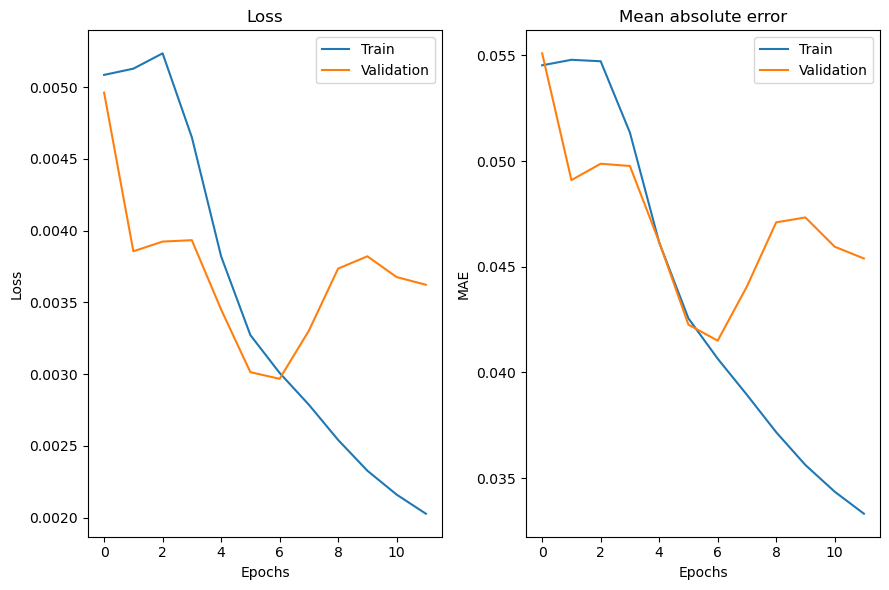

In [29]:
plot_history(mo_cnn_lstm_history)
# plot_predictions(mo_cnn_lstm, mo_sample_batch, 'multi_output')

### Evaluation 

55/55 [==============================] - 0s 2ms/step - loss: 0.0141 - mean_absolute_error: 0.0940


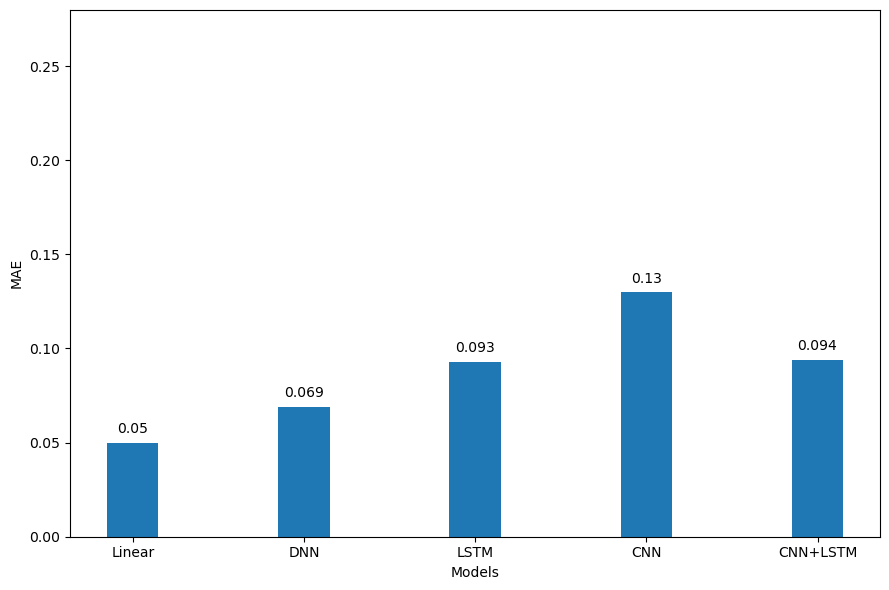

In [30]:
mo_mae = [0.05, 0.069, 0.093]

mo_mae.append(mo_cnn.evaluate(test_ds_mo)[1])
mo_mae.append(mo_cnn_lstm.evaluate(test_ds_mo)[1])

plot_evaluation(model_list, mo_mae)